In [13]:
from shapely import geometry, ops
from shapely.geometry import Point,mapping, LineString, MultiPoint
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
from scipy.ndimage import filters
import gpxpy.gpx

In [14]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7677"].geometry.cascaded_union

Haytor_map = rasterio.open(
    os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)


network_links = gpd.read_file(os.path.join('Study_area','SX7677','network_links_dpn.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','SX7677','network_nodes_dpn.geojson'))

In [15]:
network_links['angle_normalised'] = network_links['angle'].div(network_links['angle'].sum())
network_links['total_time_normalised'] = network_links['total_time'].div(network_links['total_time'].sum())
network_links['DPN_normalised'] = network_links['DPN'].div(network_links['DPN'].sum())
network_links['surface_cost_normalised'] = network_links['surface_cost'].div(network_links['surface_cost'].sum())



In [54]:
#from Haytor rocks to B3387
#points = ['int_dpn1', 'dpn_1127']

#from bottom_right to Haytor Down
#points = ['dpn_408', 'dpn_298']

#from top_righ to haytor rocks path
points = ['al_1681','int_dpn1']

In [55]:
# using point allocation
# easy = [0.2,0,0.6,0.2]
# intermediate = [0.1,0.2,0.3,0.4]
# expert = [0,0.8,0.1,0.1]

#using ranking sum
# easy = [0.2,0.1,0.4,0.3]
# intermediate = [0.1,0.3,0.4,0.2]
# expert = [0.1,0.4,0.2,0.3]


#using ranking exponent
easy = [0.014,0.003,0.89,0.093]
intermediate = [0.003,0.093,0.89,0.014]
difficult = [0.003,0.89,0.014,0.093]

#using ranking reciprocal
# easy = [0.16,0.12,0.48,0.24]
# intermediate = [0.12,0.24,0.48,0.16]
# expert = [0.12,0.48,0.16,0.24]

#using AHP
# easy= [0.40816269, 0.37576408, 0.16324949, 0.05282373]
# intermediate =[0.05483313, 0.18761354, 0.42783578, 0.32971755]
# expert = [0.03716924, 0.64349957, 0.16151403, 0.15781716]


In [56]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    #easy
    angle = (row.angle_normalised * easy[0])*100000
    travel_time = (row.total_time_normalised * easy[1])*100000
    dpn = (row.DPN_normalised * easy[2])*100000
    surface_cost = (row.surface_cost_normalised * easy[3])*100000
    # Weighted Sum method
    wsm_easy = angle + travel_time + dpn + surface_cost

    #intermediate
    angle = (row.angle_normalised * intermediate[0])*100000
    travel_time = (row.total_time_normalised * intermediate[1])*100000
    dpn = (row.DPN_normalised * intermediate[2])*100000
    surface_cost = (row.surface_cost_normalised * intermediate[3])*100000
    # Weighted Sum method
    wsm_intermediate = angle + travel_time + dpn + surface_cost

    #intermediate
    angle = (row.angle_normalised * difficult[0])*100000
    travel_time = (row.total_time_normalised * difficult[1])*100000
    dpn = (row.DPN_normalised * difficult[2])*100000
    surface_cost = (row.surface_cost_normalised * difficult[3])*100000
    # Weighted Sum method
    wsm_difficult = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'], length=row.length,
                   wsm_easy=wsm_easy,wsm_intermediate=wsm_intermediate,
                   wsm_difficult=wsm_difficult)

In [57]:
weighted_path_easy = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='wsm_easy')
weighted_path_intermediate = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='wsm_intermediate')
weighted_path_difficult = nx.dijkstra_path(graph, source=points[0], target=points[1], weight='wsm_difficult')

In [58]:
def create_path_gpd(weighted_path):
    geom = []
    links = []
    #dpn= []
    first_node = weighted_path[0]
    for node in weighted_path[1:]:
        link_fid = graph.edges[first_node, node]['fid']
        links.append(link_fid)
        row = network_links.loc[network_links['fid'] == link_fid]
        geom.append(row['geometry'].cascaded_union)
        # dpn.append(row.DPN)
        first_node = node

    #weighted_path_dpn_gpd = gpd.GeoDataFrame({'fid': links,'dpn':dpn, 'geometry': geom})
    weighted_path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
    return weighted_path_gpd

In [59]:
weighted_path_easy_gpd = create_path_gpd(weighted_path_easy)
weighted_path_intermediate_gpd = create_path_gpd(weighted_path_intermediate)
weighted_path_difficult_gpd = create_path_gpd(weighted_path_difficult)

In [60]:
def smooth_linestring(path_gpd, smooth_sigma):
    geom = path_gpd['geometry'].tolist()
    multi_line = geometry.MultiLineString(geom)
    multi_line
    linestring = ops.linemerge(multi_line)
    linestring
    start_coord = linestring.coords[0]
    end_coord = linestring.coords[-1]
    smooth_x = np.array(filters.gaussian_filter1d(
        linestring.xy[0],
        smooth_sigma)
    )
    smooth_y = np.array(filters.gaussian_filter1d(
        linestring.xy[1],
        smooth_sigma)
    )
    smoothed_coords = np.hstack((smooth_x, smooth_y))
    smoothed_coords = zip(smooth_x, smooth_y)
    smoothed_coords= [i for i in smoothed_coords]
    smoothed_coords[0] = start_coord
    smoothed_coords[-1] = end_coord
    linestring_smoothed = LineString(smoothed_coords)
    new_path_gpd = gpd.GeoSeries({'geometry': linestring_smoothed})
    return new_path_gpd

In [61]:
linestring_smoothed_easy = smooth_linestring(weighted_path_easy_gpd, 2)
linestring_smoothed_intermediate= smooth_linestring(weighted_path_intermediate_gpd, 2)
linestring_smoothed_difficult = smooth_linestring(weighted_path_difficult_gpd, 2)

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:32: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


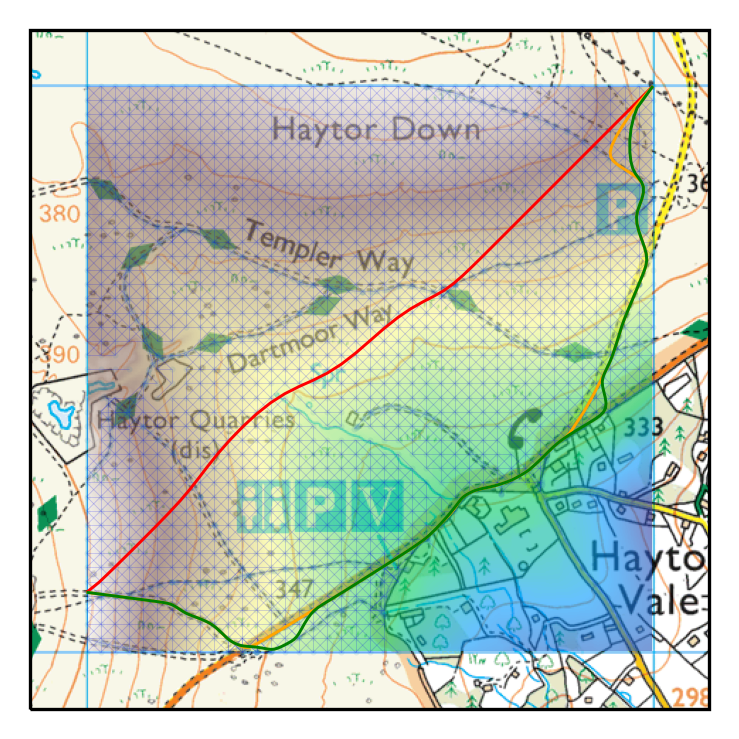

In [62]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                   cmap='terrain')

# displaying nodes
network_nodes.plot(ax=ax, zorder=3, markersize=0.2, alpha=0.1)

# displaying links
network_links.plot(ax=ax, zorder=2, edgecolor='blue', linewidth=0.2, alpha=0.1)

# display path
linestring_smoothed_easy.plot(ax=ax, zorder=7, edgecolor='green', linewidth=0.7, label='dpn')
linestring_smoothed_intermediate.plot(ax=ax, zorder=6, edgecolor='orange', linewidth=0.7, label='angle')
linestring_smoothed_difficult.plot(ax=ax, zorder=5, edgecolor='red', linewidth=0.7, label='surface cost')
#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0] - 100, study_area_shapely.bounds[2] + 100,
                   study_area_shapely.bounds[1] - 100, study_area_shapely.bounds[3] + 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

In [63]:
# linestring_smoothed_easy.to_file("Study_area/SX7677/linestring_smoothed_easy'dpn_408'-'dpn_298'.geojson", driver='GeoJSON',crs='EPSG:27700')
# linestring_smoothed_intermediate.to_file("Study_area/SX7677/linestring_smoothed_intermediate'dpn_408'-'dpn_298'.geojson", driver='GeoJSON',crs='EPSG:27700')
# linestring_smoothed_difficult.to_file("Study_area/SX7677/linestring_smoothed_difficult'dpn_408'-'dpn_298'.geojson", driver='GeoJSON',crs='EPSG:27700')

# linestring_smoothed_easy.to_file("Study_area/SX7677/linestring_smoothed_easy'int_dpn1', 'dpn_1127'.geojson", driver='GeoJSON',crs='EPSG:27700')
# linestring_smoothed_intermediate.to_file("Study_area/SX7677/linestring_smoothed_intermediate'int_dpn1', 'dpn_1127'.geojson", driver='GeoJSON',crs='EPSG:27700')
# linestring_smoothed_difficult.to_file("Study_area/SX7677/linestring_smoothed_difficult'int_dpn1', 'dpn_1127'.geojson", driver='GeoJSON',crs='EPSG:27700')

linestring_smoothed_easy.to_file("Study_area/SX7677/linestring_smoothed_easy'al_1681','int_dpn1'.geojson", driver='GeoJSON',crs='EPSG:27700')
linestring_smoothed_intermediate.to_file("Study_area/SX7677/linestring_smoothed_intermediate'al_1681','int_dpn1'.geojson", driver='GeoJSON',crs='EPSG:27700')
linestring_smoothed_difficult.to_file("Study_area/SX7677/linestring_smoothed_difficult'al_1681','int_dpn1'.geojson", driver='GeoJSON',crs='EPSG:27700')